In [ ]:
!pip install biopython matplotlib pandas openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")


Requesting UniProt ...
Total input: 15666  Cleaned kept: 15396

=== Summary ===
Total sequences analyzed: 500
Length stats (min, median, max): 191 665 1966
pI mean/std: 6.933418910980224 1.4264133046795646
GRAVY mean/std: -0.36463522113942837 0.22294978547206948


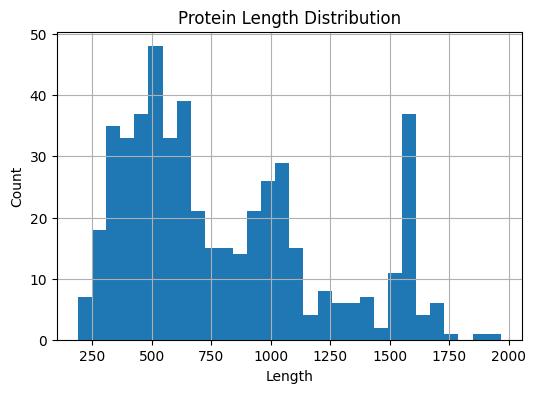

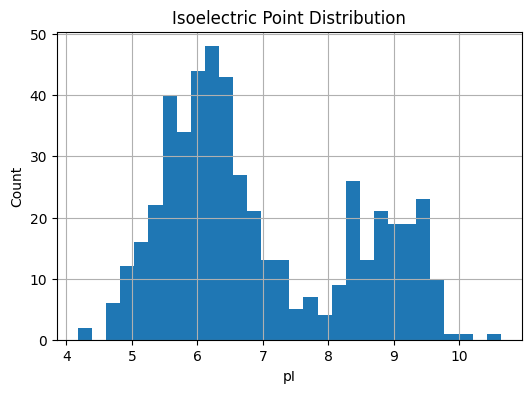

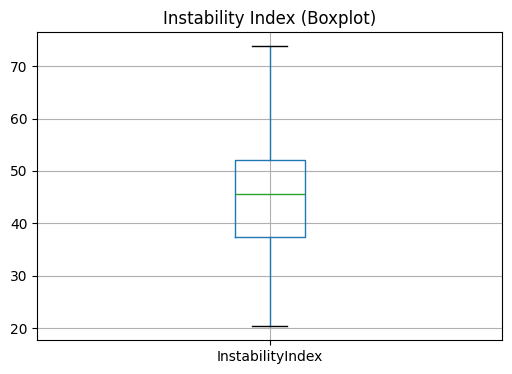

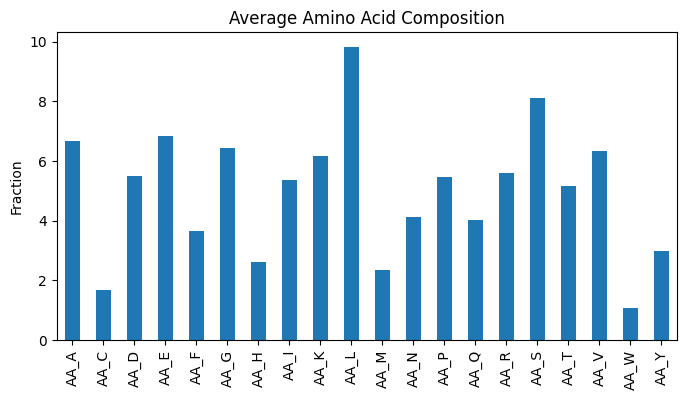

In [ ]:
# family_download_and_analyze_api.py
import os
import requests
from io import StringIO
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# User parameters
# -----------------------
QUERY = 'family:"kinase" AND reviewed:true'
MAX_SEQS = 500   # خدي limit مناسب عشان متتأخريش
MIN_LEN = 50
MAX_LEN = 2000
REMOVE_FRAGMENTS = True
REMOVE_WITH_X = True

# -----------------------
# 1) Download from UniProt API
# -----------------------
def download_from_uniprot(query, max_seqs=200):
    base = "https://rest.uniprot.org/uniprotkb/stream"
    params = {"query": query, "format": "fasta", "size": max_seqs}
    print("Requesting UniProt ...")
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    return r.text

# -----------------------
# 2) Clean FASTA
# -----------------------
def clean_fasta_text(fasta_text, min_len=50, max_len=2000,
                     remove_fragments=True, remove_with_x=True):
    records = list(SeqIO.parse(StringIO(fasta_text), "fasta"))
    cleaned = []
    for rec in records:
        seq = str(rec.seq).upper()
        desc = rec.description.lower()
        if remove_fragments and "fragment" in desc:
            continue
        if remove_with_x and ("X" in seq or "B" in seq or "Z" in seq):
            continue
        if not (min_len <= len(seq) <= max_len):
            continue
        cleaned.append(rec)
    print(f"Total input: {len(records)}  Cleaned kept: {len(cleaned)}")
    return cleaned

# -----------------------
# 3) Analyze one sequence
# -----------------------
def analyze_seqrecord(rec):
    seq = str(rec.seq).upper()
    pa = ProteinAnalysis(seq)
    aa_comp = pa.amino_acids_percent  # استخدام الجديد بدل deprecated
    mol_weight = pa.molecular_weight()
    pI = pa.isoelectric_point()
    aromaticity = pa.aromaticity()
    instability = pa.instability_index()
    gravy = pa.gravy()
    sec_struct = pa.secondary_structure_fraction()  # (helix, turn, sheet)
    return {
        "ProteinID": rec.id,
        "Description": rec.description,
        "Length": len(seq),
        "MW": mol_weight,
        "pI": pI,
        "Aromaticity": aromaticity,
        "InstabilityIndex": instability,
        "GRAVY": gravy,
        "HelixFrac": sec_struct[0],
        "TurnFrac": sec_struct[1],
        "SheetFrac": sec_struct[2],
        **{f"AA_{k}": v for k, v in aa_comp.items()}
    }

# -----------------------
# 4) Batch process
# -----------------------
def batch_process(fasta_text):
    cleaned_records = clean_fasta_text(fasta_text, MIN_LEN, MAX_LEN,
                                       REMOVE_FRAGMENTS, REMOVE_WITH_X)
    if len(cleaned_records) > MAX_SEQS:
        cleaned_records = cleaned_records[:MAX_SEQS]

    results = [analyze_seqrecord(r) for r in cleaned_records]
    df = pd.DataFrame(results)

    # -------- Summary in output --------
    print("\n=== Summary ===")
    print("Total sequences analyzed:", len(df))
    print("Length stats (min, median, max):",
          int(df.Length.min()), int(df.Length.median()), int(df.Length.max()))
    print("pI mean/std:", df.pI.mean(), df.pI.std())
    print("GRAVY mean/std:", df.GRAVY.mean(), df.GRAVY.std())

    # -------- Global figures --------
    plt.figure(figsize=(6,4))
    df["Length"].hist(bins=30)
    plt.title("Protein Length Distribution")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["pI"].hist(bins=30)
    plt.title("Isoelectric Point Distribution")
    plt.xlabel("pI")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df.boxplot(column="InstabilityIndex")
    plt.title("Instability Index (Boxplot)")
    plt.show()

    # Average amino acid composition
    aa_cols = [c for c in df.columns if c.startswith("AA_")]
    avg_aa = df[aa_cols].mean().sort_index()
    avg_aa.plot(kind="bar", figsize=(8,4))
    plt.title("Average Amino Acid Composition")
    plt.ylabel("Fraction")
    plt.show()

    return df

# -----------------------
# MAIN
# -----------------------
def main():
    fasta_text = download_from_uniprot(QUERY, max_seqs=MAX_SEQS*2)
    df = batch_process(fasta_text)

if __name__ == "__main__":
    main()
